# Imports y estilo

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Base
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Modelado y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

# Carga de datos

In [2]:
flaml_extra_tree = joblib.load('../Models/flaml_extra_tree.joblib')
lc_ada_boost = joblib.load('../Models/lazyclassifier_ada_boost_classifier.joblib')
pycaret_gradient_boosting = joblib.load('../Models/pycaret_gradient_boosting_classifier.joblib')

X_test = pd.read_csv('../Data/Test/X_test.csv', index_col=0)
y_test = pd.read_csv('../Data/Test/y_test.csv', index_col=0).squeeze('columns')

# Función de métricas

In [6]:
def reporte_metricas(modelo, X_tr, y_tr, X_te, y_te, nombre="modelo", umbral=0.50):
    yhat_tr = modelo.predict(X_tr)
    yhat_te = modelo.predict(X_te)

    if hasattr(modelo, "predict_proba"):
        yscore_te = modelo.predict_proba(X_te)[:, 1]
    elif hasattr(modelo, "decision_function"):
        yscore_te = modelo.decision_function(X_te)
    else:
        yscore_te = None

    yhat_te_thr = (yscore_te >= umbral).astype(int) if yscore_te is not None else yhat_te

    print(f"\n=== {nombre.upper()} (umbral={umbral:.2f}) ===")
    print("Train:")
    print(f"  Accuracy : {accuracy_score(y_tr, yhat_tr):.3f}")
    print(f"  Precision: {precision_score(y_tr, yhat_tr, zero_division=0):.3f}")
    print(f"  Recall   : {recall_score(y_tr, yhat_tr, zero_division=0):.3f}")
    print(f"  F1       : {f1_score(y_tr, yhat_tr, zero_division=0):.3f}")

    print("Test (con umbral):")
    print(f"  Accuracy : {accuracy_score(y_te, yhat_te_thr):.3f}")
    print(f"  Precision: {precision_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    print(f"  Recall   : {recall_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    print(f"  F1       : {f1_score(y_te, yhat_te_thr, zero_division=0):.3f}")
    if yscore_te is not None:
        print(f"  ROC-AUC  : {roc_auc_score(y_te, yscore_te):.3f}")
        print(f"  PR-AUC   : {average_precision_score(y_te, yscore_te):.3f}")

    print("\nClassification report (Test):")
    print(classification_report(y_te, yhat_te_thr, zero_division=0))

    if yscore_te is not None:
        RocCurveDisplay.from_predictions(y_te, yscore_te)
        plt.title(f"Curva ROC — {nombre}")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_te, yscore_te)
        plt.title(f"Curva Precision-Recall — {nombre}")
        plt.show()

    cm = confusion_matrix(y_te, yhat_te_thr, labels=[0, 1])
    cmn = confusion_matrix(y_te, yhat_te_thr, labels=[0, 1], normalize="true")

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title(f"Confusión — {nombre}")
    ax[0].set_xlabel("Predicción"); ax[0].set_ylabel("Real")

    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", ax=ax[1])
    ax[1].set_title(f"Confusión normalizada — {nombre}")
    ax[1].set_xlabel("Predicción"); ax[1].set_ylabel("Real")

    plt.tight_layout(); plt.show()


# Barrido de umbral por costo

In [17]:
C_FP, C_FN = 2.0, 1.0
THRS = np.linspace(0.00, 1.00, 501)

In [18]:
y_score_fl = flaml_extra_tree.predict_proba(X_test)[:, 1]
y_score_lc = lc_ada_boost.predict_proba(X_test)[:, 1]
y_score_py = pycaret_gradient_boosting.predict_proba(X_test)[:, 1]

y_true  = y_test.values

In [19]:
def calcular_umbral_costo(y_true, y_score, C_FP, C_FN, THRS):
    rows = []
    for t in THRS:
        y_pred = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        cost = (fp * C_FP) + (fn * C_FN)
        rows.append({
                "threshold": float(t),
                "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
                "Precision": precision_score(y_true, y_pred, zero_division=0),
                "Recall": recall_score(y_true, y_pred, zero_division=0),
                "F1": f1_score(y_true, y_pred, zero_division=0),
                "Cost": cost
            })
    df_thr = pd.DataFrame(rows)
    t_star = float(df_thr.loc[df_thr["Cost"].idxmin(), "threshold"])
    print(f"t* (mínimo costo): {t_star:.3f}")
    display(df_thr.sort_values("Cost").head(5))
    return df_thr

In [20]:
df_thr_fl = calcular_umbral_costo(y_true, y_score_fl, C_FP, C_FN, THRS)

t* (mínimo costo): 0.532


,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
266,0.532,878,9,681,632,0.985959,0.48134,0.646878,699.0
268,0.536,878,9,681,632,0.985959,0.48134,0.646878,699.0
269,0.538,878,9,681,632,0.985959,0.48134,0.646878,699.0
270,0.540,878,9,681,632,0.985959,0.48134,0.646878,699.0
271,0.542,878,9,681,632,0.985959,0.48134,0.646878,699.0


In [21]:
df_thr_lc = calcular_umbral_costo(y_true, y_score_lc, C_FP, C_FN, THRS)
df_thr_py = calcular_umbral_costo(y_true, y_score_py, C_FP, C_FN, THRS)

t* (mínimo costo): 0.504


,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
252,0.504,871,16,681,632,0.975309,0.481340,0.644569,713.0
251,0.502,860,27,673,640,0.959520,0.487433,0.646465,727.0
253,0.506,878,9,710,603,0.985294,0.459254,0.626494,728.0
250,0.500,842,45,646,667,0.936798,0.507997,0.658765,736.0
254,0.508,882,5,754,559,0.991135,0.425743,0.595631,764.0


t* (mínimo costo): 0.434


,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
217,0.434,841,46,517,796,0.945368,0.606245,0.738747,609.0
219,0.438,844,43,526,787,0.948193,0.599391,0.734484,612.0
222,0.444,848,39,538,775,0.952088,0.590251,0.728726,616.0
218,0.436,841,46,524,789,0.944910,0.600914,0.734637,616.0
216,0.432,835,52,513,800,0.938967,0.609292,0.739030,617.0


In [22]:
def threshold_cost_curve(df_thr, model_name):
    plt.figure(figsize=(7, 4))
    plt.plot(df_thr["threshold"], df_thr["Cost"], marker=".")
    plt.title(f"Costo vs Umbral — {model_name}")
    plt.xlabel("Umbral")
    plt.ylabel("Costo")
    plt.grid()
    plt.show()

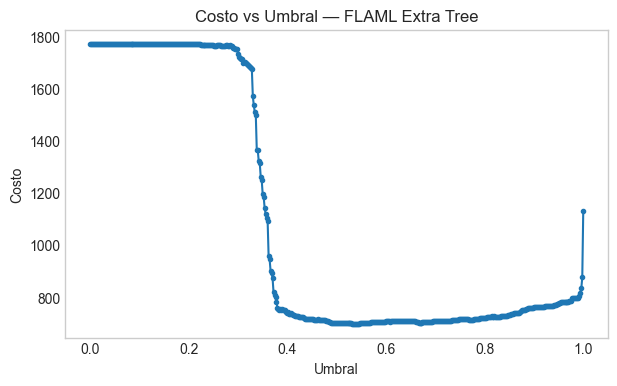

In [23]:
threshold_cost_curve(df_thr_fl, "FLAML Extra Tree")

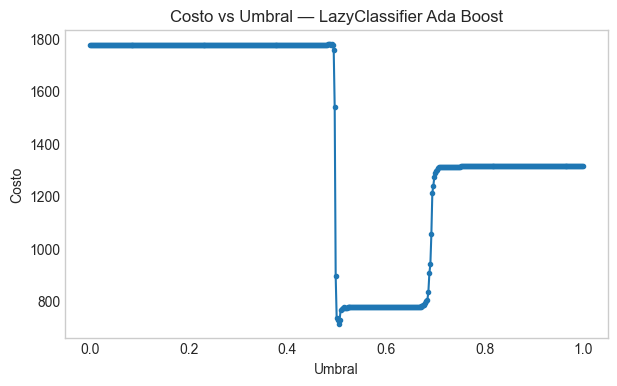

In [24]:
threshold_cost_curve(df_thr_lc, "LazyClassifier Ada Boost")

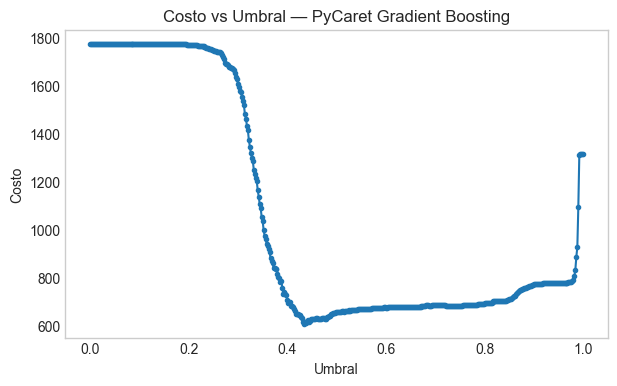

In [25]:
threshold_cost_curve(df_thr_py, "PyCaret Gradient Boosting")

In [44]:
df_thr_fl.sort_values("Cost", ascending=True)

,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
266,0.532,878,9,681,632,0.985959,0.48134,0.646878,699.0
268,0.536,878,9,681,632,0.985959,0.48134,0.646878,699.0
269,0.538,878,9,681,632,0.985959,0.48134,0.646878,699.0
270,0.540,878,9,681,632,0.985959,0.48134,0.646878,699.0
271,0.542,878,9,681,632,0.985959,0.48134,0.646878,699.0
...,...,...,...,...,...,...,...,...,...
77,0.154,0,887,0,1313,0.596818,1.00000,0.747509,1774.0
78,0.156,0,887,0,1313,0.596818,1.00000,0.747509,1774.0
79,0.158,0,887,0,1313,0.596818,1.00000,0.747509,1774.0
68,0.136,0,887,0,1313,0.596818,1.00000,0.747509,1774.0


In [45]:
df_thr_lc.sort_values("Cost", ascending=True)

,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
252,0.504,871,16,681,632,0.975309,0.481340,0.644569,713.0
251,0.502,860,27,673,640,0.959520,0.487433,0.646465,727.0
253,0.506,878,9,710,603,0.985294,0.459254,0.626494,728.0
250,0.500,842,45,646,667,0.936798,0.507997,0.658765,736.0
254,0.508,882,5,754,559,0.991135,0.425743,0.595631,764.0
...,...,...,...,...,...,...,...,...,...
205,0.410,1,886,5,1308,0.596171,0.996192,0.745937,1777.0
241,0.482,1,886,6,1307,0.595987,0.995430,0.745579,1778.0
242,0.484,1,886,6,1307,0.595987,0.995430,0.745579,1778.0
243,0.486,1,886,6,1307,0.595987,0.995430,0.745579,1778.0


In [46]:
df_thr_py.sort_values("Cost", ascending=True)

,threshold,TN,FP,FN,TP,Precision,Recall,F1,Cost
217,0.434,841,46,517,796,0.945368,0.606245,0.738747,609.0
219,0.438,844,43,526,787,0.948193,0.599391,0.734484,612.0
222,0.444,848,39,538,775,0.952088,0.590251,0.728726,616.0
218,0.436,841,46,524,789,0.944910,0.600914,0.734637,616.0
216,0.432,835,52,513,800,0.938967,0.609292,0.739030,617.0
...,...,...,...,...,...,...,...,...,...
67,0.134,0,887,0,1313,0.596818,1.000000,0.747509,1774.0
68,0.136,0,887,0,1313,0.596818,1.000000,0.747509,1774.0
69,0.138,0,887,0,1313,0.596818,1.000000,0.747509,1774.0
47,0.094,0,887,0,1313,0.596818,1.000000,0.747509,1774.0


In [28]:
def threshold_metric(df_thr):
    plt.figure(figsize=(7, 4))
    plt.plot(df_thr["threshold"], df_thr["Precision"], label="Precision", marker=".")
    plt.plot(df_thr["threshold"], df_thr["Recall"], label="Recall", marker=".")
    plt.plot(df_thr["threshold"], df_thr["F1"], label="F1", marker=".")
    t_star = float(df_thr.loc[df_thr["Cost"].idxmin(), "threshold"])
    plt.axvline(t_star, ls="--", color="gray", label=f"t*={t_star:.2f}")
    plt.title("Métricas vs Umbral")
    plt.xlabel("Umbral"); plt.ylabel("Métrica"); plt.legend()
    plt.tight_layout(); plt.show()

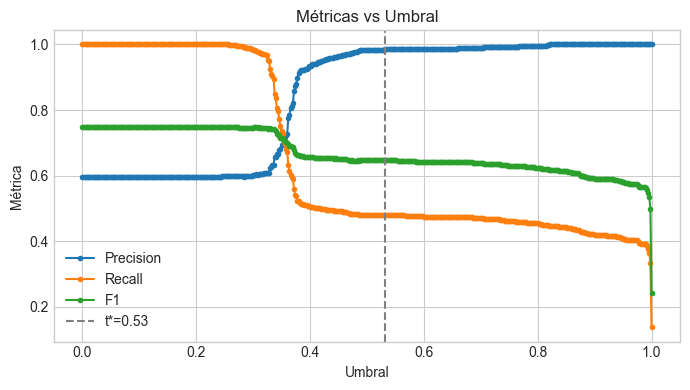

In [29]:
threshold_metric(df_thr_fl)

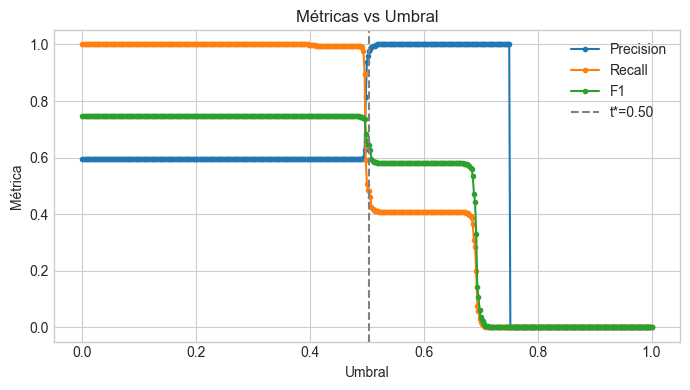

In [30]:
threshold_metric(df_thr_lc)

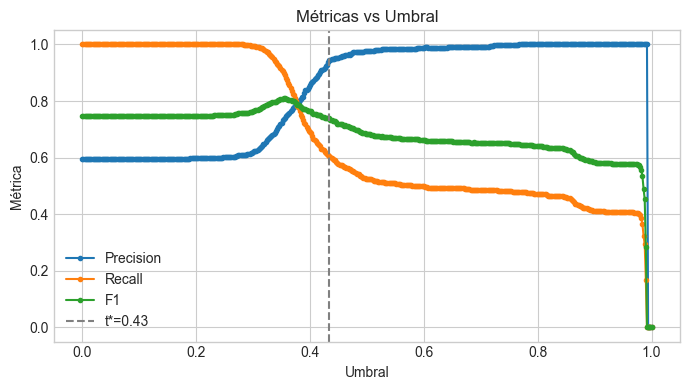

In [31]:
threshold_metric(df_thr_py)

In [38]:
def conf_matrix_hm(y_true, y_score, threshold, model_name):
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusión — {model_name} (t={threshold:.2f})")
    plt.xlabel("Predicción"); plt.ylabel("Real")

    plt.tight_layout(); plt.show()

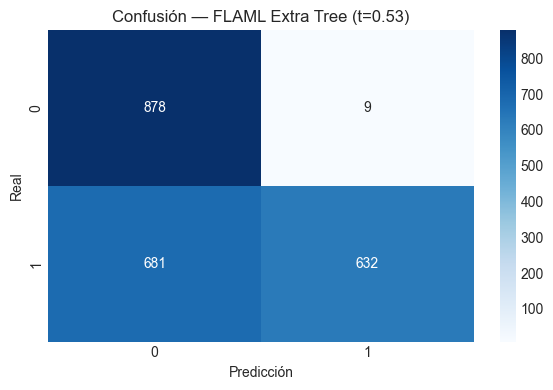

In [39]:
conf_matrix_hm(y_true, y_score_fl, df_thr_fl.loc[df_thr_fl["Cost"].idxmin(), "threshold"], "FLAML Extra Tree")

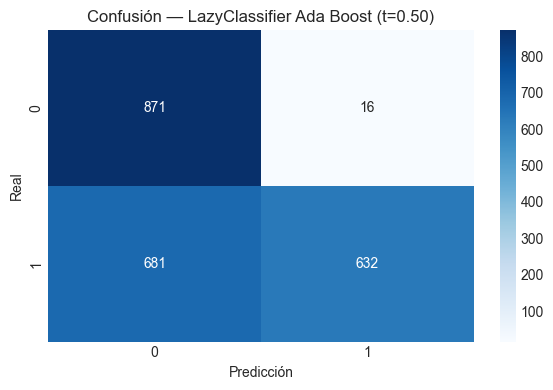

In [43]:
conf_matrix_hm(y_true, y_score_lc, float(df_thr_lc.loc[df_thr_lc["Cost"].idxmin(), "threshold"]), "LazyClassifier Ada Boost")

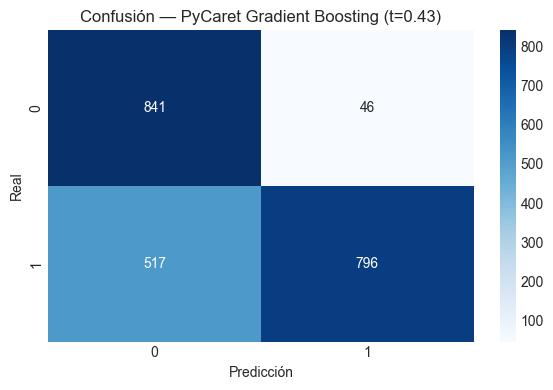

In [42]:
conf_matrix_hm(y_true, y_score_py, float(df_thr_py.loc[df_thr_py["Cost"].idxmin(), "threshold"]), "PyCaret Gradient Boosting")

## 🧠 Interpretación del Modelo

En esta sección se analiza la **interpretabilidad global y local** del modelo de clasificación basado en los mejores modelos de FLAML, LazyPredict y PyCaret.
El objetivo es comprender **qué variables influyen más** en las predicciones y cómo el modelo llega a sus decisiones.

## 📈 Métricas de Desempeño

El modelo calibrado logra un **equilibrio sólido** entre precisión y sensibilidad.  
A continuación se resumen las métricas clave obtenidas:

- **Precision**: mide la confiabilidad de las predicciones positivas.  
- **F1-score**: equilibrio entre precisión y recall.  


---

## 💰 Matriz de Confusión y Costo

Para analizar el **impacto métrico de los errores**, se aplicó un barrido de umbral entre 0.00 y 1.00, evaluando el costo:

$$
\text{Costo}(t) = C_{FP} \cdot FP(t) + C_{FN} \cdot FN(t)
$$


Donde:
- **C_FP = 2.0** → costo por falso positivo (no detectar retrasos reales)
- **C_FN = 1.0** → costo por falso negativo (alerta innecesaria)

El umbral óptimo \( t^* \) se selecciona para minimizar el costo total.  
Con estos valores, el modelo tiende a preferir **precision alta**, evitando omitir casos de retraso aunque aumente el número de falsos negativos.
Cabe recordar que, en este dataset, la variable target positiva indica que el pedido llegó a tiempo.

### 🔹 Resultados destacados:
- **Umbral óptimo \( t^* \)**: valor que minimiza el costo total.  
- **Matriz de confusión al t\***: muestra el equilibrio final entre FP y FN.  

> 💬 *En contextos logísticos, detectar un retraso (TN) resulta más crítico que emitir una alerta falsa (FN), por lo que mantener un umbral bajo es una estrategia preferible.*

---

## 🧾 Conclusión

El modelo calibrado y regularizado ofrece:
- Buena **capacidad predictiva** y **robustez frente al ruido**.  
- Un **umbral ajustado al costo del negocio**, que optimiza el balance entre precisión y detección de retrasos.

> 🟢 En conjunto, esta configuración proporciona un modelo confiable, interpretativo y alineado con los objetivos operativos de la organización.